<a href="https://colab.research.google.com/github/TanviKulkarni07/CS-MRI-Recon/blob/main/RandomRowsRemoval.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
cd /gdrive/MyDrive/

/gdrive/MyDrive


In [6]:

img1 = nib.load('HCP_mgh_1001_MR_MPRAGE_GradWarped_and_Defaced_Br_20140919084711597_S227198_I444246.nii')

In [26]:
try:
    import nibabel as nib
except:
    !pip install nibabel
    import nibabel as nib
import numpy as np
from PIL import Image
import cv2
from matplotlib import pyplot as plt
import torch
import tensorflow as tf
import torch.fft as fft

#considered saggital view for square dimension data
#for validation and evaluation
def data_load(image):
  img1_data = image.get_data()
  img_data_arr = np.asarray(img1_data)
  X=(np.uint8(np.ceil(img_data_arr.shape[1]/2)))
  #print(X)
  img_val=img_data_arr[:,:,X-5:X+5]
  return img_val

def row_Mask_test(image,c_level):
  import random
  import math
  [row,col]=image.shape
  if row%2 ==0 :
    r = np.uint8(row/2)
  else :
    r = np.uint8((row+1)/2)
  img_mask_np=np.ones([row,col])
  n = row - row/c_level
  N=random.sample(range(1, row), math.ceil(n))
  for j in N:
    if j in range(r-15,r+15):
      continue
    img_mask_np[j,:]=np.zeros([1,col])
  return img_mask_np

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  after removing the cwd from sys.path.


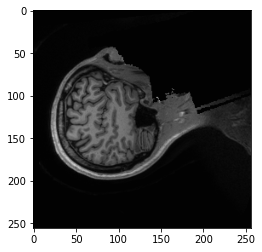

In [34]:
img_stack=data_load(img1)
test_1=img_stack[:,:,9]
plt.imshow(test_1,cmap='gray')

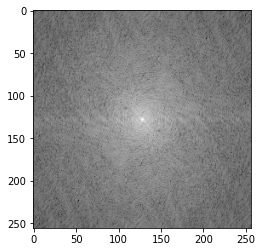

In [15]:
data = test_1.astype(np.float32)
img_torch = torch.from_numpy(data)
fft_img_torch = torch.fft.fft2(img_torch,norm="ortho")
fft_img_torch = torch.fft.fftshift(fft_img_torch) 
plt.imshow(20*np.log(torch.abs(fft_img_torch)),cmap='gray')

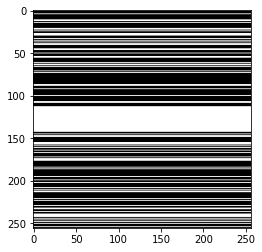

In [35]:
Mask_1=row_Mask_test(img_torch,3)
mask_tensor=torch.from_numpy(Mask_1.astype(np.float32))
plt.imshow(Mask_1,cmap='gray')


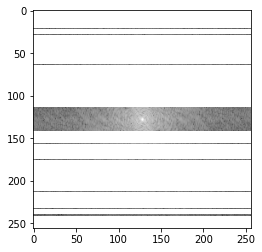

In [36]:
compressed_img_fft=torch.multiply(mask_tensor,fft_img_torch)
plt.imshow(20*torch.log(torch.abs(compressed_img_fft)),cmap='gray')

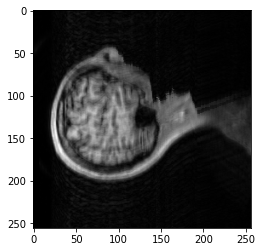

In [37]:
compressed_img = torch.fft.ifft2(torch.fft.ifftshift(compressed_img_fft))
plt.imshow((torch.abs(compressed_img)),cmap='gray')

In [38]:
from skimage.measure import compare_ssim
from skimage.metrics import peak_signal_noise_ratio
c = compressed_img.numpy()
(score, diff) = compare_ssim(np.abs(c), test_1, full=True)
psnr1 = peak_signal_noise_ratio(test_1,np.abs(c) ,data_range=test_1.max()-test_1.min())
print(score,psnr1)

0.27345895267811754 15.691843421480627


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/skimage/measure/_structural_similarity.py:17: UserWarning: Inputs have mismatched dtype.  Setting data_range based on im1.dtype.
  **kwargs)
